In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '07_10_24_OCTA_SmoothGT'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 17472 -> 17472 rows.
Finished loading inference stats.
Log amounts: log_root                                                      log_set                                              
/storage/vbutoi/scratch/ESE/inference/07_10_24_OCTA_SmoothGT  20240710_120500-1A60-841b40a08de6238fe4378595359189db    637
                                                              20240710_120505-6TNS-d0c0a2e5073091de993de9fd82d29648    637
                                                              20240710_120509-X0J5-40b46ffa3d35f132eebef1bfe5679ef6    637
                                                              20240710_120513-FM2V-cd5fefbef33c1400c1c968bafc40f797    637
                                                              20240710_120517-JZPX-0b47d891ffaf66c69a004fabec5e011a    637
                                                              20240710_120521-DP34-bcfeed29027aeb5a5bd127cde9d5d611    637
       

In [4]:
def loss_func(loss_func_class):
    if loss_func_class == "None":
        return 'Combo'
    else:
        return loss_func_class.split('.')[-1]

inference_df.augment(loss_func)

In [5]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "data_id",
    "loss_func",
    "new_gt_proportion", # This is after our resizing and blurring
    "gt_proportion",
    "soft_proportion",
    "hard_proportion",
    "experiment_pretrained_seed", 
    "model_pretrained_exp_root",
    "split",
]
# Take these columns of the inference_df, drop other columns.
exp_df = inference_df[exp_columns].drop_duplicates().reset_index(drop=True)

In [6]:
# Get number of examples we are evaluating on.
len(exp_df['data_id'].unique())

91

In [7]:
# We need to rename 'proportion' to 'proportion' for the sake of the experiment.
proportion_df = exp_df.rename(columns={
    "gt_proportion": "gt proportion",
    "new_gt_proportion": "new gt proportion",
    "hard_proportion": "hard proportion",
    "soft_proportion": "soft proportion",
})

In [8]:
# Make two new columns, one for the soft proportion error and one for the hard proportion error.
proportion_df['new gt error'] = (proportion_df['new gt proportion'] - proportion_df['gt proportion'])
proportion_df['soft error'] = (proportion_df['soft proportion'] - proportion_df['gt proportion'])
proportion_df['hard error'] = (proportion_df['hard proportion'] - proportion_df['gt proportion'])
# Make the normalized metric that divides the error by the ground truth proportion.
proportion_df['new gt relative error'] = proportion_df['new gt error'] / proportion_df['gt proportion']
proportion_df['soft relative error'] = proportion_df['soft error'] / proportion_df['gt proportion']
proportion_df['hard relative error'] = proportion_df['hard error'] / proportion_df['gt proportion']

In [9]:
proportion_df

,data_id,loss_func,new gt proportion,gt proportion,soft proportion,hard proportion,experiment_pretrained_seed,model_pretrained_exp_root,split,new gt error,soft error,hard error,new gt relative error,soft relative error,hard relative error
0,subject_10233.bmp,SoftDiceLoss,0.066862,0.065369,0.067728,0.048950,43,/storage/vbutoi/scratch/ESE/training/June_2024...,val,0.001493,0.002359,-0.016419,0.022843,0.036092,-0.251168
1,subject_10128.bmp,SoftDiceLoss,0.093999,0.091144,0.064971,0.047607,43,/storage/vbutoi/scratch/ESE/training/June_2024...,val,0.002856,-0.026173,-0.043536,0.031331,-0.287158,-0.477667
2,subject_10097.bmp,SoftDiceLoss,0.104934,0.104956,0.074483,0.066833,43,/storage/vbutoi/scratch/ESE/training/June_2024...,val,-0.000023,-0.030473,-0.038123,-0.000215,-0.290342,-0.363225
3,subject_10066.bmp,SoftDiceLoss,0.087514,0.087512,0.070715,0.061707,43,/storage/vbutoi/scratch/ESE/training/June_2024...,val,0.000001,-0.016798,-0.025806,0.000017,-0.191950,-0.294883
4,subject_10111.bmp,SoftDiceLoss,0.119270,0.118569,0.077055,0.066162,43,/storage/vbutoi/scratch/ESE/training/June_2024...,val,0.000701,-0.041513,-0.052407,0.005915,-0.350120,-0.441994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,subject_10295.bmp,SoftDiceLoss,0.095816,0.095806,0.077863,0.056885,46,/storage/vbutoi/scratch/ESE/training/June_2024...,cal,0.000010,-0.017943,-0.038921,0.000104,-0.187288,-0.406252
2908,subject_10051.bmp,SoftDiceLoss,0.085189,0.085194,0.074482,0.048828,46,/storage/vbutoi/scratch/ESE/training/June_2024...,cal,-0.000004,-0.010711,-0.036366,-0.000051,-0.125729,-0.426858
2909,subject_10159.bmp,SoftDiceLoss,0.086168,0.086131,0.075431,0.050598,46,/storage/vbutoi/scratch/ESE/training/June_2024...,cal,0.000037,-0.010700,-0.035533,0.000432,-0.124232,-0.412546
2910,subject_10096.bmp,SoftDiceLoss,0.102304,0.102288,0.088955,0.076050,46,/storage/vbutoi/scratch/ESE/training/June_2024...,cal,0.000017,-0.013332,-0.026238,0.000164,-0.130343,-0.256509


In [10]:
# Important for this experiment that we only consider the 'val' and 'cal' splits because we trained on the 'train' split.
proportion_df['split'].unique()

array(['val', 'cal'], dtype=object)

# Library Funcs

In [11]:
def prepare_error_df(raw_df, groupby_keys, value_vars, var_name, value_name):
    # Make a clone of the proportion df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=value_vars,
        var_name=var_name,
        value_name=value_name,
    )
    # Make some columns that are useful for plotting.
    error_df[f'absolute {value_name}'] = error_df[value_name].abs()
    # Return the melted dataframe.
    return error_df


def calibrator(model_pretrained_exp_root):
    if "SVLS" in model_pretrained_exp_root:
        return "SVLS"
    else:
        return "Uncalibrated"


def process_method_names(input_df, value_name):
    # Make a clone of the input_df
    df = input_df.copy()
    # Drop all the rows where calibrator != Uncalibrated AND the proportion_type is hard_proportion_error.
    df = df[~((df['calibrator'] != 'Uncalibrated') & (df['proportion_type'] == f'hard {value_name}'))]
    # Then we augment the proportion_type with the calibrator name.
    def proportion_type(calibrator, loss_func, proportion_type):
        if proportion_type in ["new gt error", "new gt relative error"]:
            return "New GT"
        elif calibrator == "Uncalibrated":
            return "Uncalibrated " + proportion_type.split(" ")[0] + f" ({loss_func})"
        else:
            return calibrator + " soft" + f" ({loss_func})"
    # Finally, sort by data_id
    df['proportion type'] = df.apply(lambda x: proportion_type(x['calibrator'], x['loss_func'], x['proportion_type']), axis=1)
    df = df.sort_values(by="data_id")
    # Drop the duplicate rows and reset the index.
    df = df.drop_duplicates().reset_index(drop=True)
    # Return the augmented dataframe.
    return df

# First, let's look at absolute error.

In [12]:
proportion_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_error_df = prepare_error_df(
    proportion_df, 
    groupby_keys=[
        "calibrator",
        "loss_func",
        "data_id", 
        "experiment_pretrained_seed", 
        "gt proportion", 
        "new gt proportion",
        "soft proportion", 
        "hard proportion",
        "split",
    ],
    value_vars=["new gt error", "soft error", "hard error"],
    var_name="proportion_type",
    value_name="error"
)
# Process the proportion types.
melted_error_df = process_method_names(raw_melted_error_df, value_name="error")

In [13]:
melted_error_df

,calibrator,loss_func,data_id,experiment_pretrained_seed,gt proportion,new gt proportion,soft proportion,hard proportion,split,proportion_type,error,absolute error,proportion type
0,Uncalibrated,PixelCELoss,subject_10003.bmp,40,0.073300,0.073309,0.060795,0.035583,val,soft error,-0.012505,0.012505,Uncalibrated soft (PixelCELoss)
1,Uncalibrated,PixelCELoss,subject_10003.bmp,45,0.073300,0.073309,0.065794,0.036194,val,hard error,-0.037106,0.037106,Uncalibrated hard (PixelCELoss)
2,Uncalibrated,PixelCELoss,subject_10003.bmp,46,0.073300,0.073309,0.063624,0.035461,val,hard error,-0.037839,0.037839,Uncalibrated hard (PixelCELoss)
3,SVLS,SoftDiceLoss,subject_10003.bmp,44,0.073300,0.073309,0.067983,0.022156,val,new gt error,0.000009,0.000009,New GT
4,Uncalibrated,SoftDiceLoss,subject_10003.bmp,44,0.073300,0.073309,0.072958,0.042480,val,hard error,-0.030820,0.030820,Uncalibrated hard (SoftDiceLoss)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275,SVLS,PixelCELoss,subject_10298.bmp,46,0.095738,0.095813,0.051434,0.014221,val,soft error,-0.044304,0.044304,SVLS soft (PixelCELoss)
7276,Uncalibrated,PixelCELoss,subject_10298.bmp,46,0.095738,0.095813,0.063703,0.036987,val,soft error,-0.032034,0.032034,Uncalibrated soft (PixelCELoss)
7277,Uncalibrated,SoftDiceLoss,subject_10298.bmp,46,0.095738,0.095813,0.072349,0.043884,val,new gt error,0.000075,0.000075,New GT
7278,Uncalibrated,SoftDiceLoss,subject_10298.bmp,47,0.095738,0.095813,0.072164,0.050171,val,new gt error,0.000075,0.000075,New GT


In [14]:
melted_error_df['proportion type'].unique()

array(['Uncalibrated soft (PixelCELoss)',
       'Uncalibrated hard (PixelCELoss)', 'New GT',
       'Uncalibrated hard (SoftDiceLoss)',
       'Uncalibrated soft (SoftDiceLoss)', 'SVLS soft (PixelCELoss)',
       'SVLS soft (SoftDiceLoss)'], dtype=object)

In [15]:
# Finally, we want to change the order that the methods appear in.
melted_error_df['proportion type'] = melted_error_df['proportion type'].astype('category')
melted_error_df['proportion type'] = melted_error_df['proportion type'].cat.reorder_categories([
    'New GT',
    'Uncalibrated hard (PixelCELoss)',
    'Uncalibrated soft (PixelCELoss)',
    'Uncalibrated hard (SoftDiceLoss)',
    'Uncalibrated soft (SoftDiceLoss)',
    'SVLS soft (PixelCELoss)',
    'SVLS soft (SoftDiceLoss)',
])

# Custom palette dictionary
custom_palette = {
    'New GT': 'red',
    'Uncalibrated hard (PixelCELoss)': 'blue',
    'Uncalibrated soft (PixelCELoss)': 'royalblue',
    'Uncalibrated hard (SoftDiceLoss)': 'darkgreen',
    'Uncalibrated soft (SoftDiceLoss)': 'mediumseagreen',
    'SVLS soft (PixelCELoss)': 'goldenrod',
    'SVLS soft (SoftDiceLoss)': 'gold',
}

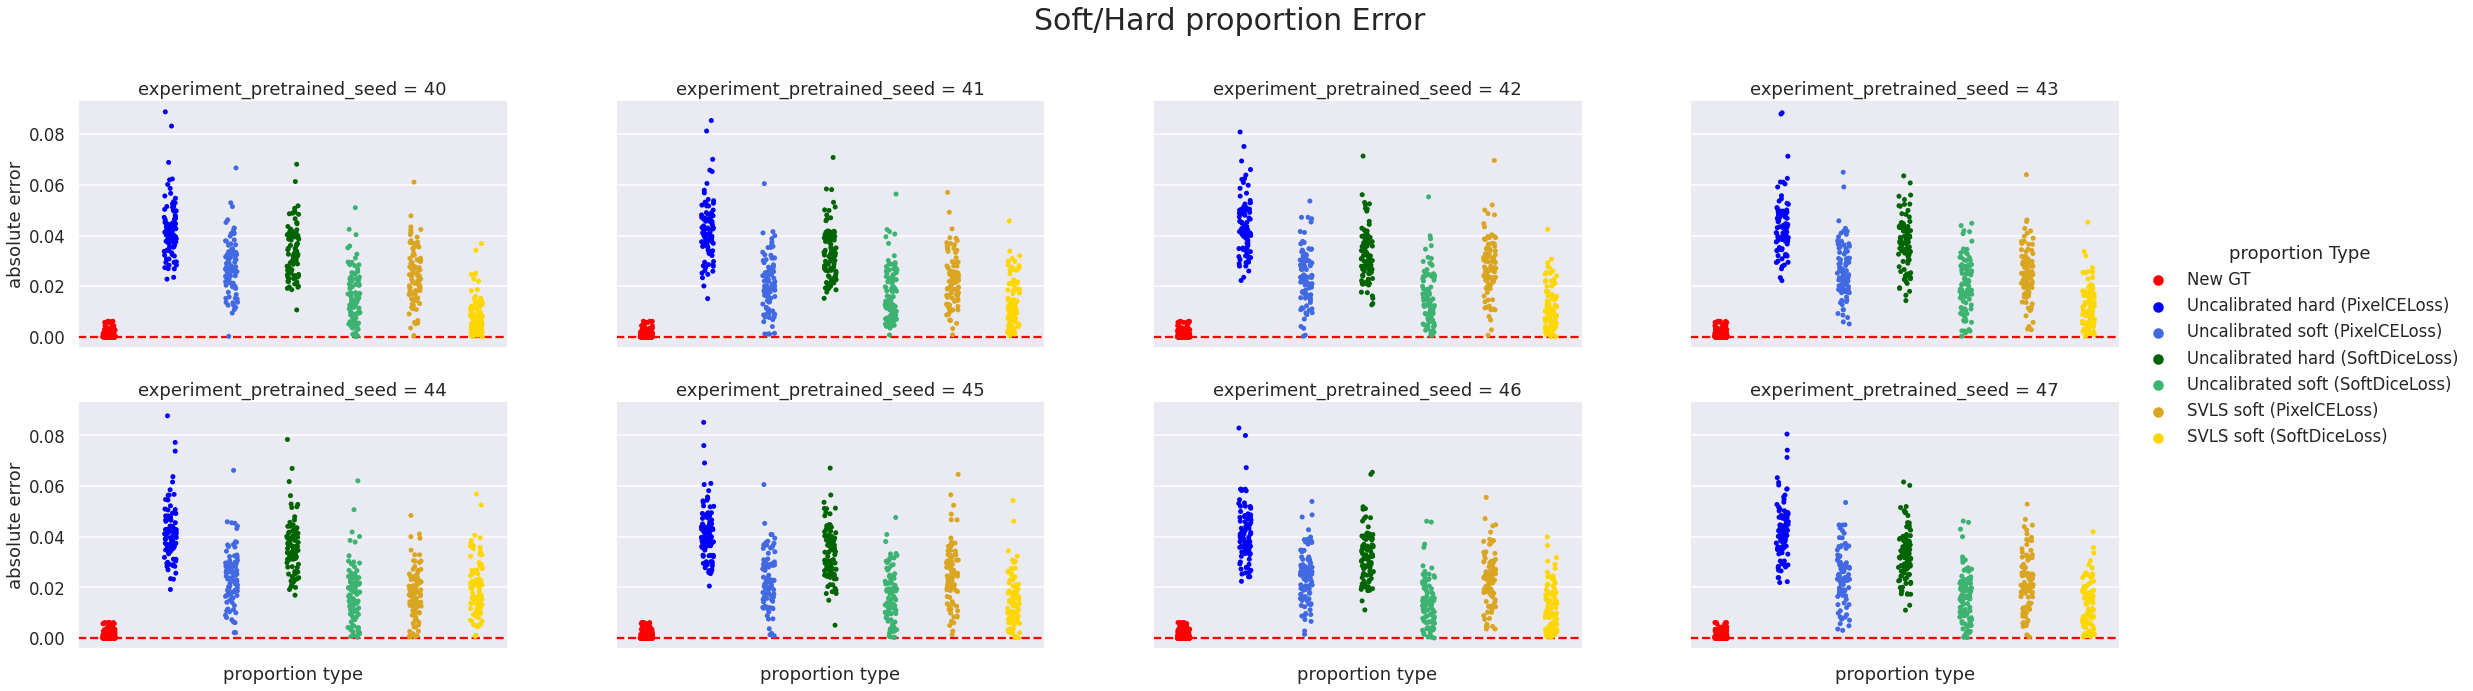

In [16]:
# Create the catplot
g = sns.catplot(
    data=melted_error_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="absolute error",
    col="experiment_pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')
    ax.set_xticklabels([])

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard proportion Error', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

In [17]:
melted_error_df

,calibrator,loss_func,data_id,experiment_pretrained_seed,gt proportion,new gt proportion,soft proportion,hard proportion,split,proportion_type,error,absolute error,proportion type
0,Uncalibrated,PixelCELoss,subject_10003.bmp,40,0.073300,0.073309,0.060795,0.035583,val,soft error,-0.012505,0.012505,Uncalibrated soft (PixelCELoss)
1,Uncalibrated,PixelCELoss,subject_10003.bmp,45,0.073300,0.073309,0.065794,0.036194,val,hard error,-0.037106,0.037106,Uncalibrated hard (PixelCELoss)
2,Uncalibrated,PixelCELoss,subject_10003.bmp,46,0.073300,0.073309,0.063624,0.035461,val,hard error,-0.037839,0.037839,Uncalibrated hard (PixelCELoss)
3,SVLS,SoftDiceLoss,subject_10003.bmp,44,0.073300,0.073309,0.067983,0.022156,val,new gt error,0.000009,0.000009,New GT
4,Uncalibrated,SoftDiceLoss,subject_10003.bmp,44,0.073300,0.073309,0.072958,0.042480,val,hard error,-0.030820,0.030820,Uncalibrated hard (SoftDiceLoss)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275,SVLS,PixelCELoss,subject_10298.bmp,46,0.095738,0.095813,0.051434,0.014221,val,soft error,-0.044304,0.044304,SVLS soft (PixelCELoss)
7276,Uncalibrated,PixelCELoss,subject_10298.bmp,46,0.095738,0.095813,0.063703,0.036987,val,soft error,-0.032034,0.032034,Uncalibrated soft (PixelCELoss)
7277,Uncalibrated,SoftDiceLoss,subject_10298.bmp,46,0.095738,0.095813,0.072349,0.043884,val,new gt error,0.000075,0.000075,New GT
7278,Uncalibrated,SoftDiceLoss,subject_10298.bmp,47,0.095738,0.095813,0.072164,0.050171,val,new gt error,0.000075,0.000075,New GT


In [18]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
error_per_seed = melted_error_df.groupby(["experiment_pretrained_seed", "proportion type"]).agg(
    abs_error=("absolute error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
error_per_seed = error_per_seed.rename(columns={"abs_error": "absolute error"})

In [19]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_error_table = error_per_seed.pivot_table(
    values="absolute error",
    index="proportion type",
    columns="experiment_pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_error_table['mean'] = method_error_table.mean(axis=1)
method_error_table['stdv'] = method_error_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_error_table = method_error_table[['mean', 'stdv']]

In [20]:
method_error_table.sort_values(by='mean')

experiment_pretrained_seed,mean,stdv
proportion type,,
New GT,0.000620,0.000000
SVLS soft (SoftDiceLoss),0.013349,0.003159
Uncalibrated soft (SoftDiceLoss),0.016764,0.001762
SVLS soft (PixelCELoss),0.023659,0.002799
Uncalibrated soft (PixelCELoss),0.024393,0.001909
Uncalibrated hard (SoftDiceLoss),0.034020,0.001443
Uncalibrated hard (PixelCELoss),0.042432,0.000822


## Second, let's look at relative error.

In [21]:
proportion_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_relative_df = prepare_error_df(
    proportion_df, 
    groupby_keys=[
        "calibrator",
        "loss_func",
        "data_id", 
        "experiment_pretrained_seed", 
        "gt proportion", 
        "new gt proportion",
        "soft proportion", 
        "hard proportion",
        "split",
    ],
    value_vars=["new gt relative error", "soft relative error", "hard relative error"],
    var_name="proportion_type",
    value_name="relative error"
)
# Process the proportion types.
melted_relative_df = process_method_names(raw_melted_relative_df, value_name="relative error")

In [22]:
melted_relative_df['proportion type'].unique()

array(['Uncalibrated soft (PixelCELoss)',
       'Uncalibrated hard (PixelCELoss)', 'New GT',
       'Uncalibrated hard (SoftDiceLoss)',
       'Uncalibrated soft (SoftDiceLoss)', 'SVLS soft (PixelCELoss)',
       'SVLS soft (SoftDiceLoss)'], dtype=object)

In [23]:
# Finally, we want to change the order that the methods appear in.
melted_relative_df['proportion type'] = melted_relative_df['proportion type'].astype('category')
melted_relative_df['proportion type'] = melted_relative_df['proportion type'].cat.reorder_categories([
    'New GT',
    'Uncalibrated hard (PixelCELoss)',
    'Uncalibrated soft (PixelCELoss)',
    'Uncalibrated hard (SoftDiceLoss)',
    'Uncalibrated soft (SoftDiceLoss)',
    'SVLS soft (PixelCELoss)',
    'SVLS soft (SoftDiceLoss)'
])
# Custom palette dictionary
custom_palette = {
    'New GT': 'red',
    'Uncalibrated hard (PixelCELoss)': 'blue',
    'Uncalibrated soft (PixelCELoss)': 'royalblue',
    'Uncalibrated hard (SoftDiceLoss)': 'darkgreen',
    'Uncalibrated soft (SoftDiceLoss)': 'mediumseagreen',
    'SVLS soft (PixelCELoss)': 'goldenrod',
    'SVLS soft (SoftDiceLoss)': 'gold',
}

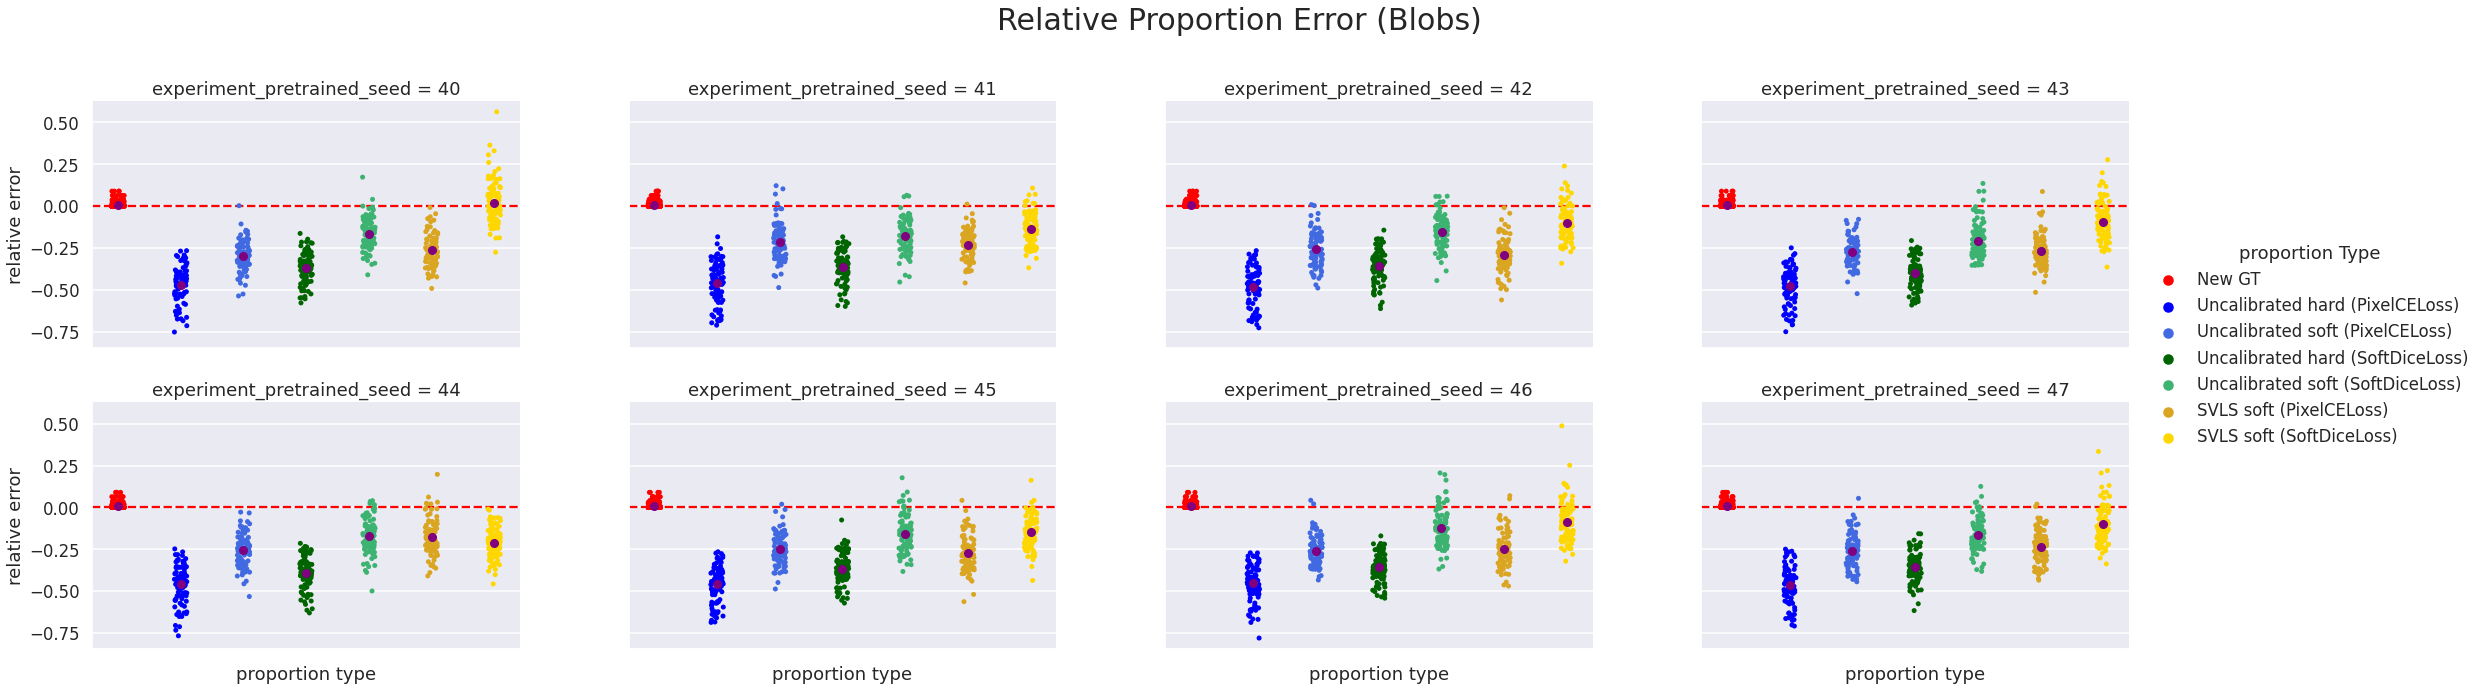

In [24]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="relative error",
    col="experiment_pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# Calculate the means
means = melted_relative_df.groupby(['experiment_pretrained_seed', 'proportion type'])['relative error'].mean().reset_index()

# For each subplot make a line at y = 0 to show the error and add the means
for ax in g.axes.flat:
    ax.axhline(0.0, ls='--', color='red')
    ax.set_xticklabels([])
    
    # Get the corresponding seed for the current subplot
    seed = ax.get_title().split(' = ')[-1]
    
    # Filter means for the current subplot
    seed_means = means[means['experiment_pretrained_seed'] == int(seed)]
    
    # Plot a purple circle at the mean position
    for _, row in seed_means.iterrows():
        ax.plot(row['proportion type'], row['relative error'], 'o', color='purple', markersize=8, zorder=10)

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Relative Proportion Error (Blobs)', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

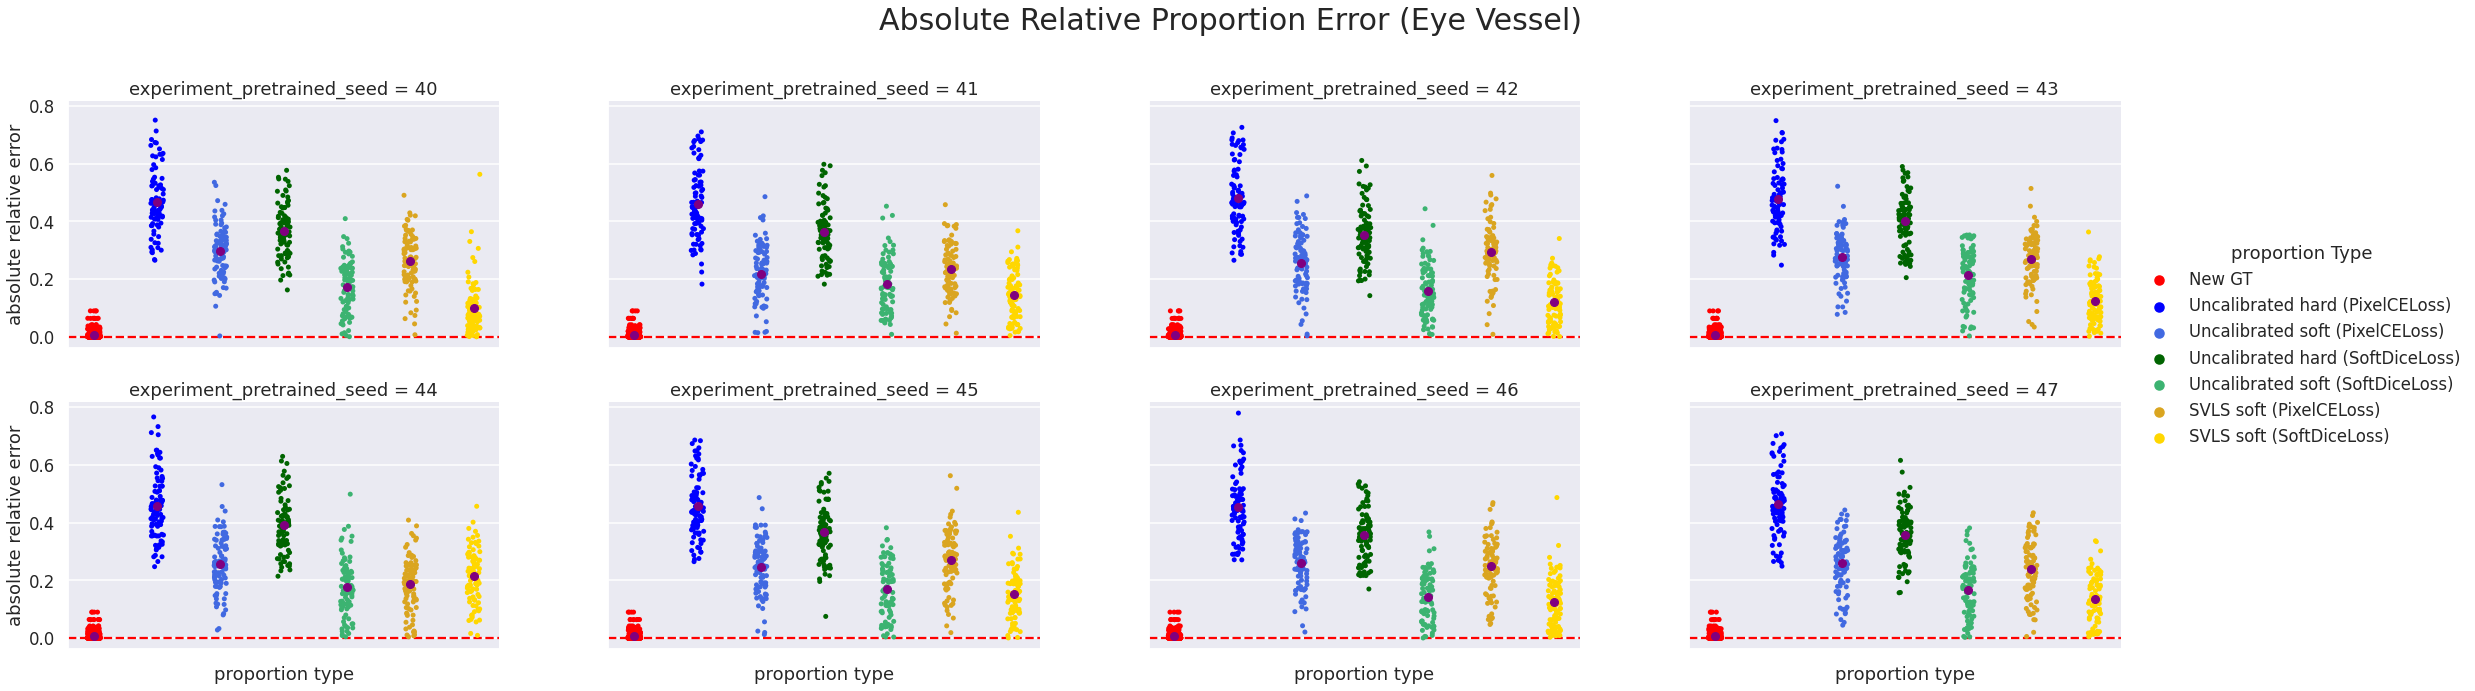

In [25]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="absolute relative error",
    col="experiment_pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# Calculate the means
means = melted_relative_df.groupby(['experiment_pretrained_seed', 'proportion type'])['absolute relative error'].mean().reset_index()

# For each subplot make a line at y = 0 to show the error and add the means
for ax in g.axes.flat:
    ax.axhline(0.0, ls='--', color='red')
    ax.set_xticklabels([])
    
    # Get the corresponding seed for the current subplot
    seed = ax.get_title().split(' = ')[-1]
    
    # Filter means for the current subplot
    seed_means = means[means['experiment_pretrained_seed'] == int(seed)]
    
    # Plot a purple circle at the mean position
    for _, row in seed_means.iterrows():
        ax.plot(row['proportion type'], row['absolute relative error'], 'o', color='purple', markersize=8, zorder=10)

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Absolute Relative Proportion Error (Eye Vessel)', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

# Let's look at this averaged over seeds.

In [26]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
relative_per_seed = melted_relative_df.groupby(["experiment_pretrained_seed", "proportion type"]).agg(
    abs_relative_error=("absolute relative error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
relative_per_seed = relative_per_seed.rename(columns={"abs_relative_error": "absolute relative error"})

In [27]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_relative_table = relative_per_seed.pivot_table(
    values="absolute relative error",
    index="proportion type",
    columns="experiment_pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_relative_table['mean'] = method_relative_table.mean(axis=1)
method_relative_table['stdv'] = method_relative_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_relative_table = method_relative_table[['mean', 'stdv']]

In [28]:
method_relative_table.sort_values(by='mean')

experiment_pretrained_seed,mean,stdv
proportion type,,
New GT,0.007741,1.734723e-18
SVLS soft (SoftDiceLoss),0.139415,3.172847e-02
Uncalibrated soft (SoftDiceLoss),0.173278,1.906944e-02
SVLS soft (PixelCELoss),0.250885,3.057143e-02
Uncalibrated soft (PixelCELoss),0.259035,2.129981e-02
Uncalibrated hard (SoftDiceLoss),0.369533,1.562994e-02
Uncalibrated hard (PixelCELoss),0.465360,9.100305e-03


# And lets look at this over Data_ids.

In [29]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
relative_per_dataid = melted_relative_df.groupby(["data_id", "proportion type"]).agg(
    abs_relative_error=("absolute relative error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
relative_per_dataid = relative_per_dataid.rename(columns={"abs_relative_error": "absolute relative error"})

In [30]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_relative_table_dataid = relative_per_dataid.pivot_table(
    values="absolute relative error",
    index="proportion type",
    columns="data_id",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_relative_table_dataid['mean'] = method_relative_table_dataid.mean(axis=1)
method_relative_table_dataid['stdv'] = method_relative_table_dataid.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_relative_table_dataid = method_relative_table_dataid[['mean', 'stdv']]

In [31]:
method_relative_table_dataid.sort_values(by='mean')

data_id,mean,stdv
proportion type,,
New GT,0.007741,0.015676
SVLS soft (SoftDiceLoss),0.139415,0.065544
Uncalibrated soft (SoftDiceLoss),0.173278,0.083423
SVLS soft (PixelCELoss),0.250885,0.082831
Uncalibrated soft (PixelCELoss),0.259035,0.079401
Uncalibrated hard (SoftDiceLoss),0.369533,0.087395
Uncalibrated hard (PixelCELoss),0.465360,0.106887


# Finally, we want to look at the Dice score and Image ECE of all three methods as we are arguing that Image ECE is what we should care about.

In [32]:
inference_df

,pred_hash,image_metric,metric_score,batch_idx,split,data_cfg_opt,label_idx,gt_proportion,data_id,gt_volume,...,model__type,model_checkpoint,model_convs_per_block,model_filters,model_in_channels,model_out_channels,model_pred_label,model_pretrained_exp_root,model_pretrained_select_metric,loss_func
0,6162808177570880805,Dice,3.914174e-01,0,val,split:val,-1,0.065369,subject_10233.bmp,1095.466309,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss
1,6162808177570880805,HD95,1.389244e+01,0,val,split:val,-1,0.065369,subject_10233.bmp,1095.466309,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss
2,6162808177570880805,BoundaryIOU,1.245330e-10,0,val,split:val,-1,0.065369,subject_10233.bmp,1095.466309,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss
3,6162808177570880805,SoftVolumeError,1.418994e+01,0,val,split:val,-1,0.065369,subject_10233.bmp,1095.466309,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss
4,6162808177570880805,HardVolumeError,-2.934663e+02,0,val,split:val,-1,0.065369,subject_10233.bmp,1095.466309,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20379,-6614904821213271975,Dice Loss,2.297362e-01,6,cal,split:cal,-1,0.095806,subject_10295.bmp,1569.853271,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss
20380,-5113756761410418200,Dice Loss,3.235121e-01,7,cal,split:cal,-1,0.085194,subject_10051.bmp,1395.743164,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss
20381,-7803090649115477806,Dice Loss,4.143763e-01,7,cal,split:cal,-1,0.086131,subject_10159.bmp,1411.784302,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss
20382,1658937705822353029,Dice Loss,2.654437e-01,7,cal,split:cal,-1,0.102288,subject_10096.bmp,1676.152832,...,standard,max-val-dice_score,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/June_2024...,val-dice_score,SoftDiceLoss


In [33]:
# Get the relevant columns for looking at the Dice score and Image ECE
metric_cols = [
    "data_id",
    "loss_func",
    "experiment_pretrained_seed",
    "model_pretrained_exp_root",
    "split",
    "image_metric",
    "metric_score"
]
# Take these columns of the inference_df, drop other columns and delete duplicate rows.
metric_df = inference_df[metric_cols].drop_duplicates().reset_index(drop=True)
metric_df.augment(calibrator)
# Drop the 'pretrained_exp_root column
metric_df = metric_df.drop(columns=["model_pretrained_exp_root"])

In [34]:
def train_method(calibrator, loss_func):
    return calibrator + f" ({loss_func})"

metric_df.augment(train_method)

In [35]:
metric_df

,data_id,loss_func,experiment_pretrained_seed,split,image_metric,metric_score,calibrator,train_method
0,subject_10233.bmp,SoftDiceLoss,43,val,Dice,3.914174e-01,Uncalibrated,Uncalibrated (SoftDiceLoss)
1,subject_10233.bmp,SoftDiceLoss,43,val,HD95,1.389244e+01,Uncalibrated,Uncalibrated (SoftDiceLoss)
2,subject_10233.bmp,SoftDiceLoss,43,val,BoundaryIOU,1.245330e-10,Uncalibrated,Uncalibrated (SoftDiceLoss)
3,subject_10233.bmp,SoftDiceLoss,43,val,SoftVolumeError,1.418994e+01,Uncalibrated,Uncalibrated (SoftDiceLoss)
4,subject_10233.bmp,SoftDiceLoss,43,val,HardVolumeError,-2.934663e+02,Uncalibrated,Uncalibrated (SoftDiceLoss)
...,...,...,...,...,...,...,...,...
20379,subject_10295.bmp,SoftDiceLoss,46,cal,Dice Loss,2.297362e-01,Uncalibrated,Uncalibrated (SoftDiceLoss)
20380,subject_10051.bmp,SoftDiceLoss,46,cal,Dice Loss,3.235121e-01,Uncalibrated,Uncalibrated (SoftDiceLoss)
20381,subject_10159.bmp,SoftDiceLoss,46,cal,Dice Loss,4.143763e-01,Uncalibrated,Uncalibrated (SoftDiceLoss)
20382,subject_10096.bmp,SoftDiceLoss,46,cal,Dice Loss,2.654437e-01,Uncalibrated,Uncalibrated (SoftDiceLoss)


In [36]:
# Groupby the pretrained_seed and image_metrics, and calibrator, and take the mean of the metric_score.
metric_per_seed = metric_df.groupby(["experiment_pretrained_seed", "loss_func", "image_metric", "train_method"]).agg(
    metric_score=("metric_score", "mean"),
).reset_index()

In [37]:
# Finally, we want to change the order that the methods appear in.
metric_per_seed['train_method'] = metric_per_seed['train_method'].astype('category')
metric_per_seed['train_method'] = metric_per_seed['train_method'].cat.reorder_categories([
    'Uncalibrated (PixelCELoss)',
    'Uncalibrated (SoftDiceLoss)',
    'SVLS (PixelCELoss)',
    'SVLS (SoftDiceLoss)',
])

In [38]:
result = metric_per_seed.groupby(['train_method', 'image_metric']).agg(
    mean_metric_score=('metric_score', 'mean'),
    std_metric_score=('metric_score', 'std')
).reset_index()

# Pivot the table to have one row for each train_method
result = result.pivot(
    index='train_method', 
    columns='image_metric', 
    values=[
        'mean_metric_score', 
        'std_metric_score'
    ]
)

# Flatten the column multi-index
result.columns = ['_'.join(col).strip() for col in result.columns.values]
result = result.reset_index()

In [39]:
result

,train_method,mean_metric_score_BoundaryIOU,mean_metric_score_Dice,mean_metric_score_Dice Loss,mean_metric_score_HD95,mean_metric_score_HardVolumeError,mean_metric_score_Image_ECE,mean_metric_score_SoftVolumeError,std_metric_score_BoundaryIOU,std_metric_score_Dice,std_metric_score_Dice Loss,std_metric_score_HD95,std_metric_score_HardVolumeError,std_metric_score_Image_ECE,std_metric_score_SoftVolumeError
0,Uncalibrated (PixelCELoss),0.002390,0.662523,0.337477,14.224933,-705.309802,0.047687,-408.295504,0.000070,0.002794,0.002794,0.309093,14.395570,0.002154,35.522481
1,Uncalibrated (SoftDiceLoss),0.002246,0.679173,0.320827,12.967586,-567.488374,0.053563,-275.442575,0.000043,0.002586,0.002586,0.412589,25.271699,0.001495,35.485198
2,SVLS (PixelCELoss),0.005090,0.394282,0.605718,29.855749,-1135.353758,0.034877,-395.749266,0.000327,0.012041,0.012041,2.030859,19.606368,0.004888,51.435330
3,SVLS (SoftDiceLoss),0.003567,0.512865,0.487135,26.672933,-932.302934,0.027571,-188.924859,0.000286,0.019625,0.019625,1.056208,57.452928,0.001638,96.768348


In [40]:
# Get all the of the columns that are 'calibrator' and have 'Dice_Loss' in them
dice_cols = [col for col in result.columns if 'Dice Loss' in col or 'train_method' in col]
dice_result = result[dice_cols]

In [41]:
# Drop the index and show
dice_result.sort_values(by='mean_metric_score_Dice Loss')

,train_method,mean_metric_score_Dice Loss,std_metric_score_Dice Loss
1,Uncalibrated (SoftDiceLoss),0.320827,0.002586
0,Uncalibrated (PixelCELoss),0.337477,0.002794
3,SVLS (SoftDiceLoss),0.487135,0.019625
2,SVLS (PixelCELoss),0.605718,0.012041


In [42]:
# Get all the of the columns that are 'calibrator' and have 'Image_ECE' in them
image_ece_cols = [col for col in result.columns if 'Image_ECE' in col or 'train_method' in col]
ece_result = result[image_ece_cols]

In [43]:
ece_result.sort_values(by='mean_metric_score_Image_ECE')

,train_method,mean_metric_score_Image_ECE,std_metric_score_Image_ECE
3,SVLS (SoftDiceLoss),0.027571,0.001638
2,SVLS (PixelCELoss),0.034877,0.004888
0,Uncalibrated (PixelCELoss),0.047687,0.002154
1,Uncalibrated (SoftDiceLoss),0.053563,0.001495
